# Week 5 
# Baltimore Crime Dataset
## Name :  Mandar Sanjay Chaudhari
## Reg : 220968222
## Section & Batch : B-1

In [7]:
#import libraries
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from datetime import datetime
from sklearn import preprocessing

In [8]:
#load the dataset
crime_data = pd.read_csv('BPD_Part_1_Victim_Based_Crime_Data.csv')

crime_data['CrimeDate'] = pd.to_datetime(crime_data['CrimeDate'])
crime_data['CrimeCode_str'] = crime_data['CrimeCode'].astype(str)
larceny_data = crime_data[crime_data['CrimeCode_str'].str.startswith('6')]
burglary_data = crime_data[crime_data['CrimeCode_str'].str.startswith('5')]

larceny_ts = larceny_data.groupby('CrimeDate').size().resample('D').sum().fillna(0)
burglary_ts = burglary_data.groupby('CrimeDate').size().resample('D').sum().fillna(0)

crime_ts = pd.DataFrame({'Larceny': larceny_ts, 'Burglary': burglary_ts})

In [9]:
#split the data into training (2014-2015) and testing (2016)
train_data = crime_ts['2014-01-01':'2015-12-31']
test_data = crime_ts['2016-01-01':'2016-12-31']

#normalize the data
train_mean = train_data.mean()
train_std = train_data.std()
train_data_norm = (train_data - train_mean) / train_std
test_data_norm = (test_data - train_mean) / train_std

In [10]:
#create time series generators for RNN and LSTM
sequence_length = 30  # Use the past 30 days to predict the next day
batch_size = 32

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
train_gen = TimeseriesGenerator(train_data_norm.values, train_data_norm.values, length=sequence_length, batch_size=batch_size)
test_gen = TimeseriesGenerator(test_data_norm.values, test_data_norm.values, length=sequence_length, batch_size=batch_size)

In [11]:
#function to build and train the models (RNN and LSTM)
def build_rnn_model(input_shape):
    model = Sequential([
        SimpleRNN(64, return_sequences=True, input_shape=input_shape),
        SimpleRNN(64, return_sequences=True),
        SimpleRNN(64, return_sequences=True),
        SimpleRNN(64),
        Dense(2)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        LSTM(64, return_sequences=True),
        LSTM(64, return_sequences=True),
        LSTM(64),
        Dense(2)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [12]:
#train the models
input_shape = (sequence_length, 2)  

rnn_model = build_rnn_model(input_shape)
lstm_model = build_lstm_model(input_shape)

rnn_model.fit(train_gen, epochs=20, verbose=1)
lstm_model.fit(train_gen, epochs=20, verbose=1)

Epoch 1/20
22/22 [==============================] - 7s 21ms/step - loss: 1.0853
Epoch 2/20
22/22 [==============================] - 1s 22ms/step - loss: 0.8356
Epoch 3/20
22/22 [==============================] - 1s 22ms/step - loss: 0.7036
Epoch 4/20
22/22 [==============================] - 1s 22ms/step - loss: 0.6300
Epoch 5/20
22/22 [==============================] - 1s 22ms/step - loss: 0.5752
Epoch 6/20
22/22 [==============================] - 1s 22ms/step - loss: 0.5154
Epoch 7/20
22/22 [==============================] - 1s 22ms/step - loss: 0.4833
Epoch 8/20
22/22 [==============================] - 1s 22ms/step - loss: 0.4192
Epoch 9/20
22/22 [==============================] - 0s 21ms/step - loss: 0.3835
Epoch 10/20
22/22 [==============================] - 1s 22ms/step - loss: 0.3472
Epoch 11/20
22/22 [==============================] - 0s 21ms/step - loss: 0.3090
Epoch 12/20
22/22 [==============================] - 0s 21ms/step - loss: 0.2890
Epoch 13/20
22/22 [==================

In [13]:
#make predictions for the test data
rnn_predictions = rnn_model.predict(test_gen)
lstm_predictions = lstm_model.predict(test_gen)

#inverse transform the predictions
rnn_predictions = rnn_predictions * train_std.values + train_mean.values
lstm_predictions = lstm_predictions * train_std.values + train_mean.values

9/9 [==============================] - 3s 21ms/step


In [14]:
#calculate MAPE and RMSE for both models
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

test_values = test_data[sequence_length:].values
rnn_mape = mean_absolute_percentage_error(test_values, rnn_predictions)
lstm_mape = mean_absolute_percentage_error(test_values, lstm_predictions)

rnn_rmse = np.sqrt(mean_squared_error(test_values, rnn_predictions))
lstm_rmse = np.sqrt(mean_squared_error(test_values, lstm_predictions))

print(f"RNN MAPE: {rnn_mape:.4f}, RMSE: {rnn_rmse:.4f}")
print(f"LSTM MAPE: {lstm_mape:.4f}, RMSE: {lstm_rmse:.4f}")

RNN MAPE: 0.3125, RMSE: 10.8116
LSTM MAPE: 0.2427, RMSE: 9.0413


The LSTM model has lower MAPE and RMSE values for both Larceny and Burglary compared to the RNN, indicating that the LSTM is performing better in terms of both error.

For the RNN, use 15 epochs for optimal learning.

For the LSTM, 10–12 epochs should be enough for adequate learning. Training beyond this point does not significantly reduce the loss.

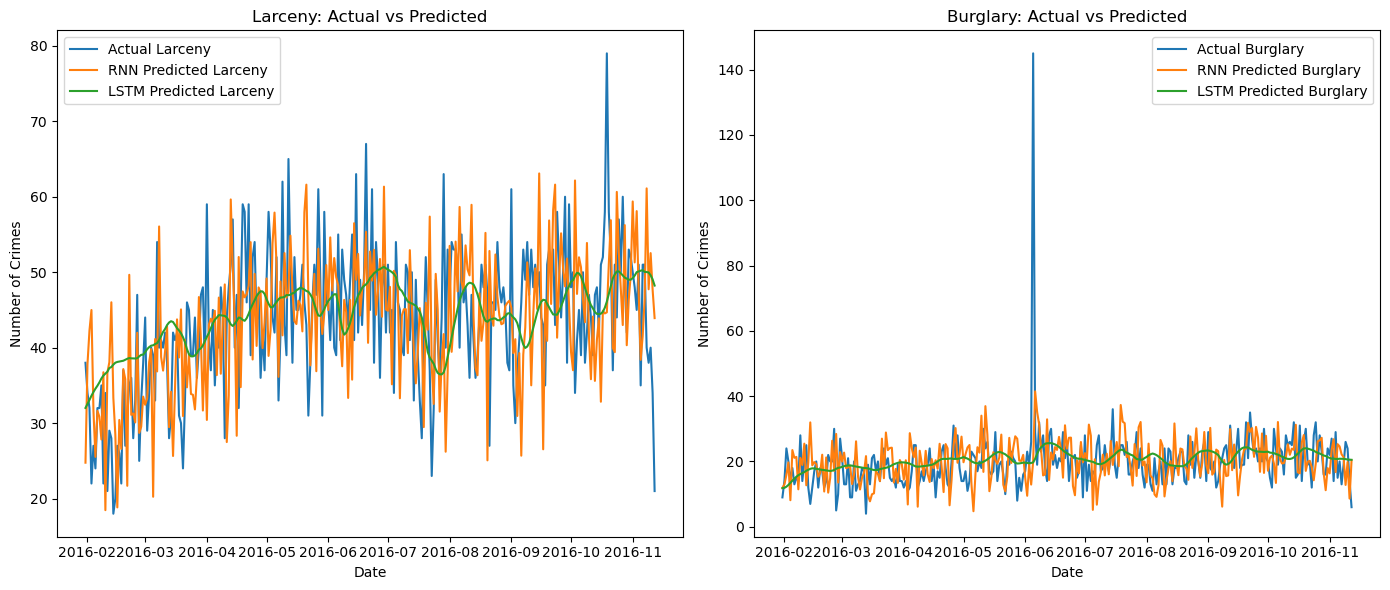

In [15]:
#plot actual vs predicted values
dates = test_data.index[sequence_length:]

import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))

#plot Larceny crimes
plt.subplot(1, 2, 1)
plt.plot(dates, test_values[:, 0], label='Actual Larceny')
plt.plot(dates, rnn_predictions[:, 0], label='RNN Predicted Larceny')
plt.plot(dates, lstm_predictions[:, 0], label='LSTM Predicted Larceny')
plt.title('Larceny: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.legend()

#plot Burglary crimes
plt.subplot(1, 2, 2)
plt.plot(dates, test_values[:, 1], label='Actual Burglary')
plt.plot(dates, rnn_predictions[:, 1], label='RNN Predicted Burglary')
plt.plot(dates, lstm_predictions[:, 1], label='LSTM Predicted Burglary')
plt.title('Burglary: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.legend()

plt.tight_layout()
plt.show()